# Task 1

## Summary

In this notebook, we explore the ability of a QAOA-style circuit in preparing a given four-qubit quantum state. The circuit is made of layers of alternating operators, which contain variational parameters that we optimize to prepare the given state. The circuit's ability to prepare a given quantum state is quantified by a cost function, which is calculated for a number of layers.

## Technical description

The cost function we are trying to minimize at the end of the circuit is:

$$
\varepsilon = \min_{\theta}|||\psi(\theta)\rangle - |\phi\rangle|| 
$$

where $|\psi(\theta)\rangle$ is the output state of the circuit, and we choose (without loss of generality) 

$$
|\phi\rangle = |1111\rangle
$$

## Analysis

The initial state of the qubits is $|\psi\rangle = |0000\rangle$. A layer in the circuit can be described as a unitary operator, $U(\{\theta_i\})$, composed of the product of an odd and even block.

The operator for the odd block is 

$$
U_{odd} = \bigotimes_{i=1}^4 R_x(\theta_i)
$$

The operator for the even block is

$$
U_{even} = \left(\prod_{\langle i,j \rangle}CZ(i,j)\right)\bigotimes_{k=1}^4 R_z(\theta_k)
$$

Where $\langle i,j \rangle$ denotes the ordered pairs of qubits.

The operator for the layer is:

$$
U_{layer}(\{\theta_i\}) = U_{even}U_{odd}
$$

The final state of the qubits is $|\psi(\theta_i)\rangle = U(\{\theta_i\})|\psi\rangle$. The operator corresponding to $n$ layers is 

$$ 
U^{(n)}(\{\theta\}) = \prod_k^n U(\{\theta_i\})
$$ 

where $\{\theta\} = \bigcup_n \{\theta_i\}$.

## Implementation

In the Python code below, we calculate $\varepsilon$ by first constructing $U^{(n)}(\{\theta\})$, then multiplying it with $|0000\rangle$ to get $|\psi(\theta)\rangle$. For the minimization, we use the `autograd` library and employ SGD

<a href="https://colab.research.google.com/github/trentfridey/qosf-screening/blob/master/Task1FromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import autograd.numpy as np
from autograd import grad
from functools import reduce
from autograd.misc.optimizers import sgd
import matplotlib.pyplot as plt

In [123]:
def epsilon(n_layers, debug=False):

  print("Number of Layers: {}".format(n_layers))
  # Operators

  sx = np.array([[0,1],[1,0]])
  sy = np.array([[0,-1j],[1j,0]])
  sz = np.array([[1,0],[0,-1]])

  p0 = np.array([[1,0],[0,0]])
  p1 = np.array([[0,0],[0,1]])

  # Gates

  def Rx(theta):
    return np.array([[np.cos(0.5*theta), -1j*np.sin(0.5*theta)],
                     [-1j*np.sin(0.5*theta), np.cos(0.5*theta)]])

  def Ry(theta):
    return np.array([[np.cos(0.5*theta), -1*np.sin(0.5*theta)],
                     [np.sin(0.5*theta), np.cos(0.5*theta)]])

  def Rz(theta):
    return np.array([[np.exp(-0.5j*theta), 0], [0, np.exp(0.5j*theta)]])

  def CZ(i,j):
    ops0 = [np.eye(2) for i in range(4)]
    ops1 = [np.eye(2) for i in range(4)]
    ops0[i] = p0
    ops1[i] = p1
    ops1[j] = sz
    cz0 = reduce(lambda res, op: np.kron(res, op), ops0)
    cz1 = reduce(lambda res, op: np.kron(res, op), ops1)
    return cz0 + cz1

  # Blocks

  def odd(thetas):
    rot = Rx(thetas[0])
    rots = [Rx(theta) for theta in thetas[1:]]
    for r in rots:
      rot = np.kron(rot,r)
    return rot

  def even(thetas):
    rot = Rx(thetas[0])
    rots = [Rz(theta) for theta in thetas[1:]]
    for r in rots:
      rot = np.kron(rot, r)
    CZs = np.eye(16)
    for i in range(3):
      for j in range(i+1, 4):
        CZs = CZ(i,j) @ CZs
    return CZs @ rot

  # Layer

  def layer(thetas):
    return even(thetas[4:8]) @ odd(thetas[0:4]) 

  # Circuit

  def circuit(thetas):
    circuit = np.eye(16)
    for l in range(n_layers):
      circuit = layer(thetas[8*l:8*(l+1)]) @ circuit
    return circuit

  # Objective

  start_state = np.array([1] + [0 for i in range(1,16)])
  target = np.array([0 for i in range(0,15)] + [1])

  def objective(thetas,iter):
    circ = circuit(thetas)
    return np.sum(np.abs(np.dot(circ, start_state) - target))

  # Optimization

  grad_obj = grad(objective)

  init_thetas = np.random.normal(0, np.pi, 8*n_layers)
  step_size = 0.1
  num_iters = 400 + 20*n_layers

  def handle_step(params, iter, grad):
    if iter % 20 == 0 and debug:
      print("Cost after {} steps is {}".format(iter, objective(params, iter)))

  optimized_thetas = sgd(grad_obj, init_thetas, step_size=step_size, num_iters=num_iters, callback=handle_step)

  epsilon = objective(optimized_thetas,0)
  if debug:
    opt_circuit = circuit(optimized_thetas)
    final_state = np.dot(opt_circuit, start_state) 
    return optimized_thetas, opt_circuit, final_state, epsilon
  return epsilon

In [128]:
# Generate data for plot

def gen_data_points():
  return [epsilon(n_layers) for n_layers in range(1,5)]

e_data = gen_data_points()

Number of Layers: 1
Number of Layers: 2
Number of Layers: 3
Number of Layers: 4


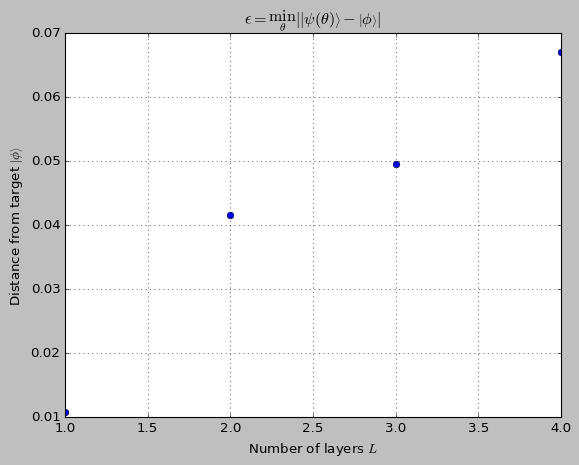

In [129]:
plt.style.use("classic")
fig, ax = plt.subplots()
ax.grid()
ax.plot(np.array([i+1 for i in range(len(e_data))]), e_data, marker="o", linestyle="")
ax.set_title(r'$\varepsilon = \min_{\theta}|\left|\psi(\theta)\right\rangle - \left|\phi\right\rangle|$')
ax.set_xlabel(r'Number of layers $L$')
ax.set_ylabel(r'Distance from target $\left|\phi\right\rangle$');